In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
import statsmodels.formula.api as smf


In [2]:
pvtw = pd.read_csv("pvtw_merged_with_parliament_1997_2024.csv")
pvtw.shape

(78112, 50)

In [3]:
pvtw.columns

Index(['Unnamed: 0', 'event_id_cnty', 'event_date', 'time_precision',
       'disorder_type', 'event_type', 'sub_event_type', 'actor1',
       'assoc_actor_1', 'inter1', 'actor2', 'assoc_actor_2', 'inter2',
       'interaction', 'civilian_targeting', 'iso', 'Subregion', 'country',
       'admin1', 'admin2', 'admin3', 'location', 'latitude', 'longitude',
       'geo_precision', 'source', 'source_scale', 'notes', 'fatalities',
       'tags', 'timestamp', 'Month', 'Year', 'Region', 'Lower Total Seat',
       'Lower Total Women', 'Lower Chamber Women (%)', 'Upper Total Seat',
       'Upper Total Women', 'Upper Chamber Women (%)', 'Rank',
       'Suspended Parliament', 'Structure of Parliament', 'Region_meta',
       'IPU Membership', 'Political System', 'Transitional Status',
       'gender_equality', 'themes', 'gender_quota'],
      dtype='object')

In [4]:
pvtw['civilian_targeting'] = pvtw['civilian_targeting'].map({'Civilian targeting': 1}).fillna(0)

In [5]:
missing_lower_women_data = pvtw[pvtw['Lower Total Seat'].isna()][['country', 'Subregion', 'Region']]
print(missing_lower_women_data['country'].unique())

['Palestine' 'Taiwan' 'Reunion' 'Kosovo' 'French Guiana' 'Puerto Rico'
 'Sint Maarten' 'Mayotte' 'Bailiwick Of Guernsey' 'Greenland'
 'New Caledonia' 'Martinique' 'Caribbean Netherlands' 'French Polynesia'
 'Guam' 'Saint-Martin' 'Guadeloupe' 'Curacao']


In [109]:
pvtw = pvtw[~(pvtw['country'].isin(missing_lower_women_data))]
pvtw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 78111 entries, 0 to 78111
Data columns (total 51 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Unnamed: 0               78111 non-null  int64         
 1   event_id_cnty            78111 non-null  object        
 2   event_date               78111 non-null  datetime64[ns]
 3   time_precision           78111 non-null  int64         
 4   disorder_type            78111 non-null  object        
 5   event_type               78111 non-null  object        
 6   sub_event_type           78111 non-null  object        
 7   actor1                   78111 non-null  object        
 8   assoc_actor_1            57338 non-null  object        
 9   inter1                   78111 non-null  object        
 10  actor2                   28029 non-null  object        
 11  assoc_actor_2            24829 non-null  object        
 12  inter2                   28029 non-nu

In [8]:
def plot(kind, data, x, y, title, xlabel, ylabel, legend=True, hue=None, grid=True, legend_kwargs=None,figsize=None,rotation=None,ha=None, **kwargs):
    """
    A flexible function to plot different kinds of graphs using Seaborn.
    Parameters:
        kind (str): The type of plot (e.g., 'line', 'scatter', 'bar', etc.).
        data (DataFrame): The dataset to use for the plot.
        x (str): The column name for the x-axis.
        y (str): The column name for the y-axis.
        title (str): The title of the plot.
        xlabel (str): The label for the x-axis.
        ylabel (str): The label for the y-axis.
        legend (bool): Whether to show the legend (default: True).
        hue (str): The column name for grouping (default: None).
        grid (bool): Whether to display a grid (default: True).
        legend_kwargs (dict): Additional arguments for customizing the legend (default: None).
        **kwargs: Additional keyword arguments for the specific Seaborn plot.
    """
    sns.set_palette("bright")
    # Create a new figure if needed
    plt.figure(figsize=(8, 6))
    if figsize is not None:
        plt.figure(figsize=figsize)
    
    # Dynamically call the appropriate Seaborn plot function
    plot_func = getattr(sns, f"{kind}plot", None)
    if plot_func is None:
        raise ValueError(f"Plot type '{kind}' is not supported by Seaborn.")
    
    # If plotting a boxplot, explicitly pass the palette
    if kind == 'box':
        plot_func(data=data, x=x, y=y, hue=hue, palette="bright", **kwargs)
    else:
        plot_func(data=data, x=x, y=y, hue=hue, **kwargs)

    # # Create the plot
    # plot_func(data=data, x=x, y=y, hue=hue, **kwargs)
    
    # Add titles and labels
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    
    # Add legend if applicable
    if legend and hue:
        if legend_kwargs is None:
            legend_kwargs = {}
        plt.legend(title=hue, **legend_kwargs)
    
    if grid:
        # Add grid for better readability
        plt.grid(True, linestyle='--', alpha=0.6)
    
    if rotation is not None:
        plt.xticks(rotation=rotation, ha = ha)
    
    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

Correlation (Log Fatalities): -0.12339333985544891


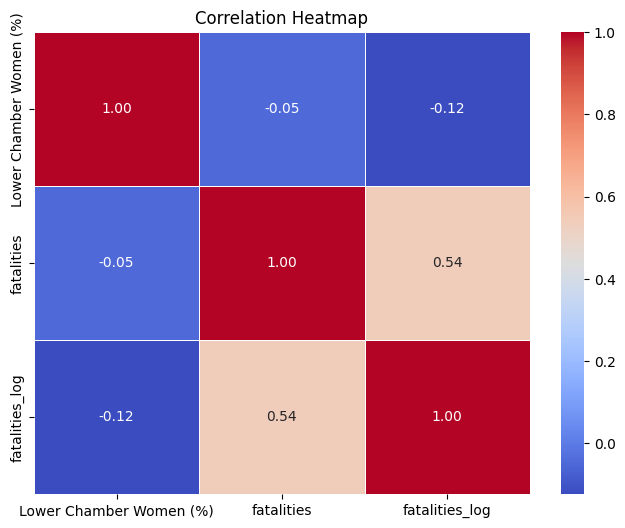

                     index  Lower Chamber Women (%)  fatalities  \
0  Lower Chamber Women (%)                 1.000000   -0.045328   
1               fatalities                -0.045328    1.000000   
2           fatalities_log                -0.123393    0.538739   

   fatalities_log  
0       -0.123393  
1        0.538739  
2        1.000000  
Correlation between Women's Representation and Fatalities: -0.04532755642902388


In [9]:
# Select relevant columns
correlation_data = pvtw[['Lower Chamber Women (%)', 'fatalities']]

# Filter out zero fatalities
correlation_data = correlation_data[correlation_data['fatalities'] > 0]

# Drop NaN values (modify in place)
correlation_data.dropna(inplace=True)
correlation_data['fatalities_log'] = np.log((1+correlation_data['fatalities']))
correlation_women_fatalities = correlation_data['Lower Chamber Women (%)'].corr(correlation_data['fatalities_log'])
print("Correlation (Log Fatalities):", correlation_women_fatalities)

corr_matrix = correlation_data.corr()

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

plt.title("Correlation Heatmap")
plt.show()


# Check if data is empty after filtering
if correlation_data.empty:
    print("No non-zero fatality events available for correlation analysis.")
else:
    # Calculate correlation matrix
    correlation_matrix = correlation_data.corr().reset_index()
    print(correlation_matrix)

    # Calculate specific correlation between women's representation and fatalities
    correlation_women_fatalities = correlation_data['Lower Chamber Women (%)'].corr(correlation_data['fatalities'])
    print("Correlation between Women's Representation and Fatalities:", correlation_women_fatalities)

correlation can't see clearly in the overall dataset

<Figure size 800x600 with 0 Axes>

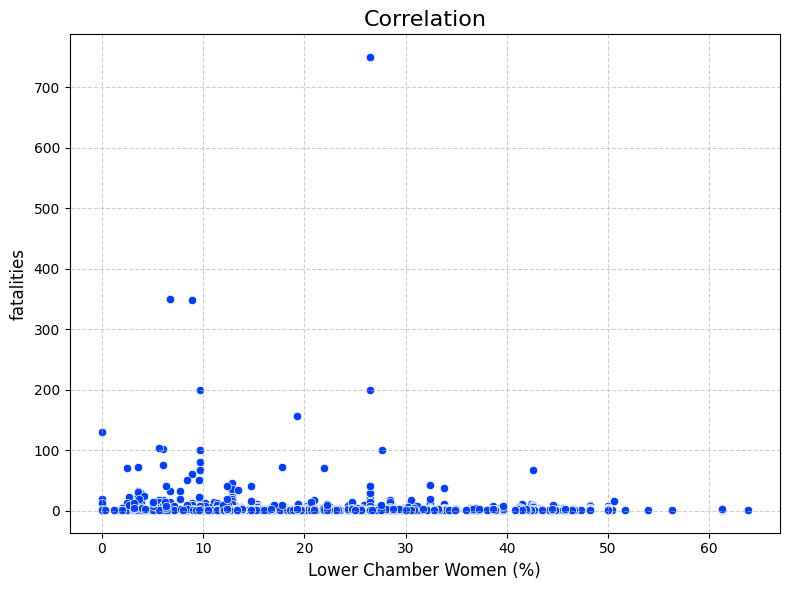

In [10]:
plot('scatter',correlation_data,'Lower Chamber Women (%)','fatalities','Correlation','Lower Chamber Women (%)','fatalities',
     figsize=(8,6))

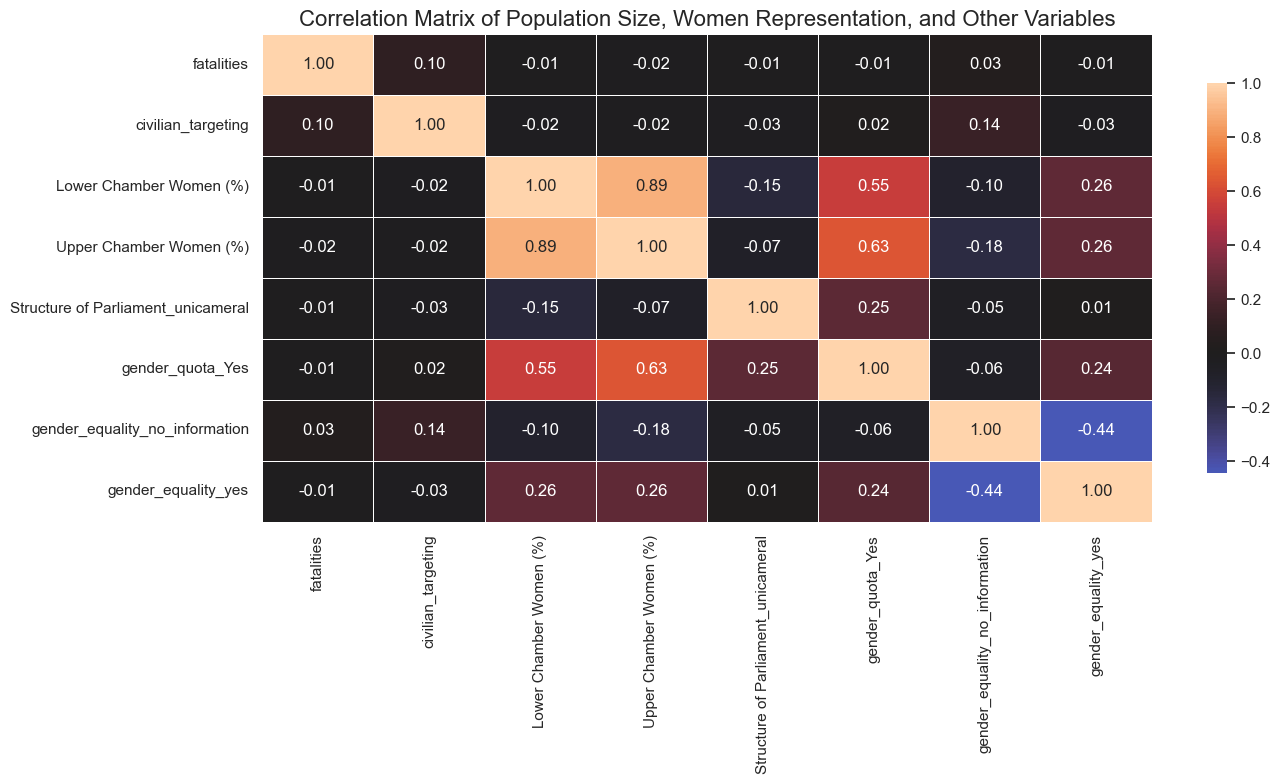

In [11]:
# Select relevant variables for the correlation matrix
correlation_df =pvtw[['fatalities', 'civilian_targeting','Lower Chamber Women (%)', 'Upper Chamber Women (%)',
                            'Structure of Parliament','gender_quota','gender_equality']]

# Convert categorical variables (Structure of Parliament, Political System, Region) to numerical values
correlation_df = pd.get_dummies(correlation_df, drop_first=True)

# Calculate the correlation matrix
corr_matrix = correlation_df.corr()

# Plot the heatmap
plt.figure(figsize=(14, 8))
sns.set(style="whitegrid")
sns.heatmap(corr_matrix, annot=True, fmt='.2f', linewidths=0.5, center=0, cbar_kws={'shrink': 0.8})
plt.title('Correlation Matrix of Population Size, Women Representation, and Other Variables', fontsize=16)
plt.tight_layout()

Overall trend might mislead -due to rarity of fatality over the years. There are lots of non fatality cases and non normality data.
DO furthur analysis on monthly aggregated data.
There are no strong correlation in overall trend, need furthur analysis to avoid bias across datasets

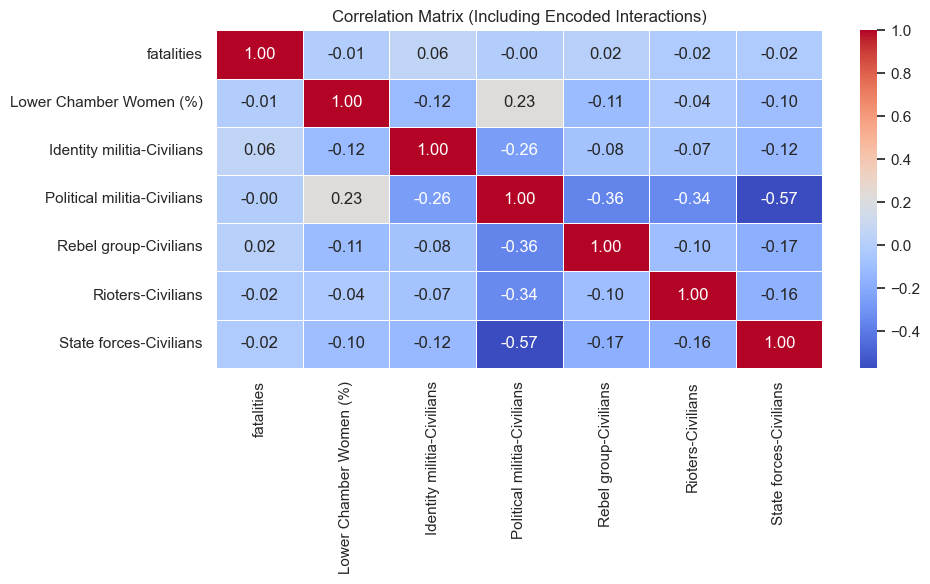

In [12]:
# Define the selected interactions
selected_interactions = [
    "Political militia-Civilians",
    "State forces-Civilians",
    "Rebel group-Civilians",
    "Rioters-Civilians",
    "Identity militia-Civilians"
]

# Filter data
filtered_pvtw = pvtw[pvtw['interaction'].isin(selected_interactions)]

# One-hot encode 'interaction' column
interaction_dummies = pd.get_dummies(filtered_pvtw['interaction'])

# Combine with numerical columns
correlation_df = pd.concat([
    filtered_pvtw[['fatalities', 'Lower Chamber Women (%)']], 
    interaction_dummies
], axis=1)

# Compute correlation matrix
corr_matrix = correlation_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix (Including Encoded Interactions)")
plt.tight_layout()
plt.show()

In [13]:
# First, ensure 'event_date' column is in datetime format
pvtw['event_date'] = pd.to_datetime(pvtw['event_date'], errors='coerce')

C:\Users\nuwai\AppData\Local\Temp\ipykernel_11336\267585253.py:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  pvtw['event_date'] = pd.to_datetime(pvtw['event_date'], errors='coerce')


Correlation between Monthly Fatalities and Average Lower Chamber Women Representation: 
                          total_fatalities  avg_women_representation
total_fatalities                  1.000000                  0.483354
avg_women_representation          0.483354                  1.000000


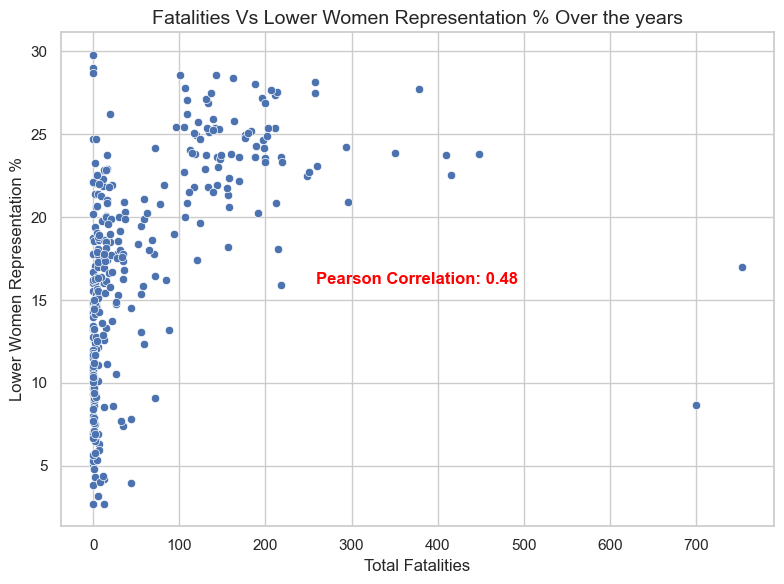

In [14]:
# Filter the data to include only relevant columns for the analysis
monthly_data = pvtw[['event_date', 'fatalities', 'Lower Chamber Women (%)', 'civilian_targeting','Transitional Status']]

# Group by month and calculate sum of fatalities, mean of women representation, and mean of civilian targeting
monthly_aggregated_data = monthly_data.groupby(monthly_data['event_date'].dt.to_period('M')).agg(
    total_fatalities=('fatalities', 'sum'),
    avg_women_representation=('Lower Chamber Women (%)', 'mean'),
    civilian_targeting=('civilian_targeting', 'mean'), # Mean to calculate proportion of civilian targeting
    transitional_status_proportion=('Transitional Status', lambda x: x.mean()),
    transitional_status=('Transitional Status', 'first'),
    number_of_events = ('fatalities','size')
).reset_index()


# Step 2: Calculate the correlation between monthly fatalities and average lower representation
correlation = monthly_aggregated_data[['total_fatalities', 'avg_women_representation']].corr()
print("Correlation between Monthly Fatalities and Average Lower Chamber Women Representation: ")
print(correlation)

# Create scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x='total_fatalities', y='avg_women_representation', data=monthly_aggregated_data)

# Calculate Pearson correlation
correlation = monthly_aggregated_data[['total_fatalities', 'avg_women_representation']].corr().iloc[0, 1]
# Annotate the correlation value at the center of the graph
plt.text(x=0.5, y=0.5, s=f'Pearson Correlation: {correlation:.2f}', 
         horizontalalignment='center', verticalalignment='center', 
         transform=plt.gca().transAxes, fontsize=12, color='red', weight='bold')

# Set plot labels and title
plt.title('Fatalities Vs Lower Women Representation % Over the years', fontsize=14)
plt.xlabel('Total Fatalities')
plt.ylabel('Lower Women Representation %')
# Show plot
plt.tight_layout()
plt.show()

Furthur analyse after removing outliers and see still see the correlation to avoid the outliers driving the correlation.

Correlation after removing outliers (<700 fatalities):
                          total_fatalities  avg_women_representation
total_fatalities                  1.000000                  0.604048
avg_women_representation          0.604048                  1.000000


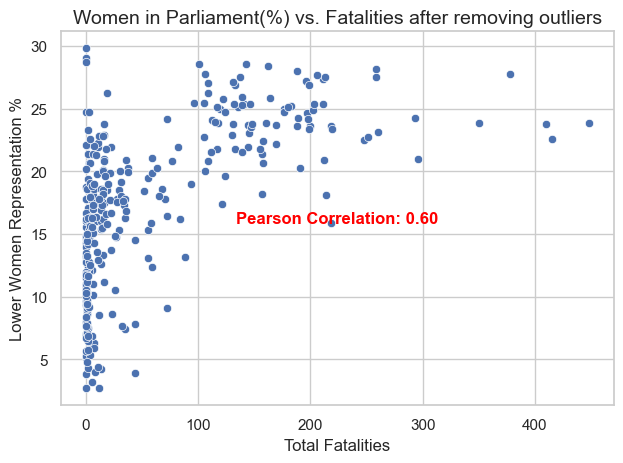

In [15]:
#filtered_data['log_fatalities'] = np.log1p(filtered_data['total_fatalities'])  # log(1+x) to avoid log(0)
filtered_data = monthly_aggregated_data[monthly_aggregated_data['total_fatalities'] < 700]
correlation = filtered_data[['total_fatalities', 'avg_women_representation']].corr()
print("Correlation after removing outliers (<700 fatalities):")
print(correlation)

correlation = filtered_data[['total_fatalities', 'avg_women_representation']].corr().iloc[0, 1]

sns.scatterplot(x='total_fatalities', y='avg_women_representation', data=filtered_data)

# Annotate the correlation value at the center of the graph
plt.text(x=0.5, y=0.5, s=f'Pearson Correlation: {correlation:.2f}', 
         horizontalalignment='center', verticalalignment='center', 
         transform=plt.gca().transAxes, fontsize=12, color='red', weight='bold')

# Set plot labels and title
plt.title('Women in Parliament(%) vs. Fatalities after removing outliers', fontsize=14)
plt.xlabel('Total Fatalities')
plt.ylabel('Lower Women Representation %')
# Show plot
plt.tight_layout()
plt.show()

0.83


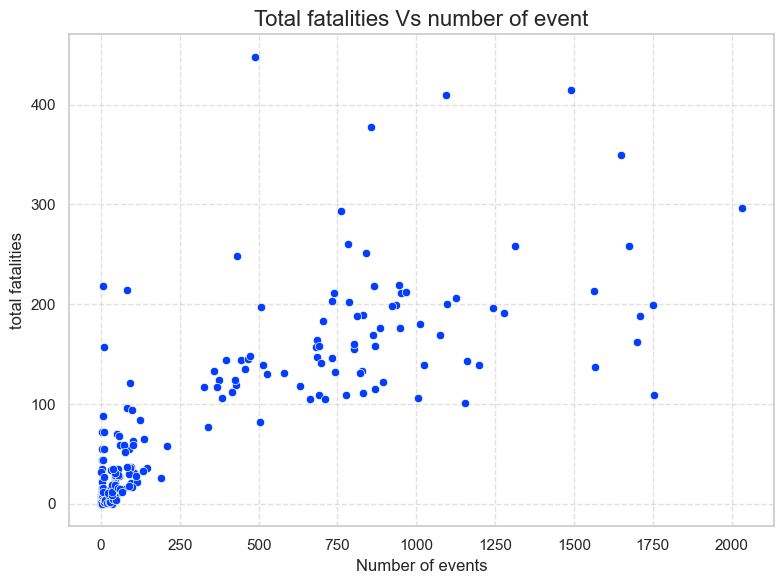

In [16]:
# Calculate Pearson correlation
correlation = round(filtered_data['number_of_events'].corr(filtered_data['total_fatalities']),2)
print(correlation)
plot('scatter',filtered_data,'number_of_events','total_fatalities',"Total fatalities Vs number of event",'Number of events',
     'total fatalities')

Since the number of events and total fatalities have a positive relationship, as expected, I will use only total fatalities as a feature to avoid redundancy and minimize the risk of double-counting effects in statistical tests.

In [17]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 320 entries, 0 to 321
Data columns (total 7 columns):
 #   Column                          Non-Null Count  Dtype    
---  ------                          --------------  -----    
 0   event_date                      320 non-null    period[M]
 1   total_fatalities                320 non-null    int64    
 2   avg_women_representation        320 non-null    float64  
 3   civilian_targeting              320 non-null    float64  
 4   transitional_status_proportion  320 non-null    float64  
 5   transitional_status             320 non-null    object   
 6   number_of_events                320 non-null    int64    
dtypes: float64(3), int64(2), object(1), period[M](1)
memory usage: 20.0+ KB


In [18]:
filtered_data

,event_date,total_fatalities,avg_women_representation,civilian_targeting,transitional_status_proportion,transitional_status,number_of_events
0,1997-01,44,3.933333,1.000000,0.000000,False,3
1,1997-02,5,3.200000,1.000000,0.000000,False,1
2,1997-03,9,17.800000,1.000000,0.000000,False,1
3,1997-04,12,2.700000,0.500000,0.000000,False,2
4,1997-06,0,3.850000,1.000000,0.000000,False,2
...,...,...,...,...,...,...,...
317,2024-07,155,21.784363,0.295143,0.015896,True,803
318,2024-08,111,21.520293,0.270758,0.007926,False,831
319,2024-09,139,25.285406,0.222222,0.017454,False,1026
320,2024-10,160,23.822055,0.284289,0.014946,False,802


c:\Users\nuwai\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


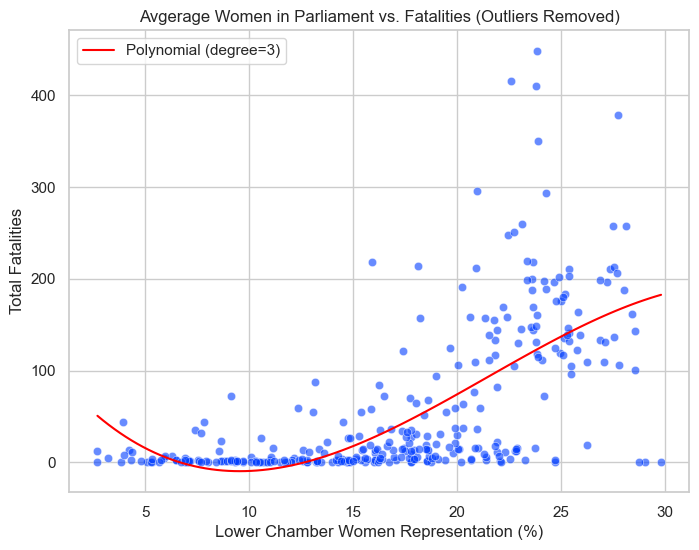

In [19]:
# polynomial after filtering outliers, >700
degree = 3  # Keep it quadratic
poly = PolynomialFeatures(degree)
X_poly = poly.fit_transform(filtered_data[['avg_women_representation']])

# Fit the model
model = LinearRegression()
model.fit(X_poly, filtered_data['total_fatalities'])

XX = np.linspace(filtered_data['avg_women_representation'].min(), 
                 filtered_data['avg_women_representation'].max(), 100).reshape(-1, 1)
XX_poly = poly.transform(XX)
y_pred = model.predict(XX_poly)

plt.figure(figsize=(8,6))
sns.scatterplot(x='avg_women_representation', y='total_fatalities', data=filtered_data, alpha=0.6)
plt.plot(XX, y_pred, color='red', label=f'Polynomial (degree={degree})')
plt.xlabel('Lower Chamber Women Representation (%)')
plt.ylabel('Total Fatalities')
plt.title('Avgerage Women in Parliament vs. Fatalities (Outliers Removed)')
plt.legend()
plt.show()

Polynomial regression is designed to model relationships that are non-linear but assumes that the data follows a specific functional form, like quadratic or cubic relationships. If data is non-linear but doesn’t follow a polynomial trend (e.g., if there are outliers or the data is skewed), the polynomial features might overfit the data and introduce patterns that aren't truly reflective of the relationship between the variables.

Given that I used Spearman's correlation and Mann-Whitney U tests, which are non-parametric methods (not assuming any specific distribution or linear relationship), it suggests that a more flexible or robust model (like a Negative Binomial regression or non-parametric tests) is better suited fo rdata. Polynomial regression might not capture the true relationship and could distort the actual associations.

Polynomial fit: The degree-3 polynomial successfully models the non-linear relationship. The correlation of 0.6 suggests that while there is a positive relationship between the two variables, it is not strong enough to conclude a simple linear dependency.
<!-- Log transformation: This helps make the data more linear and reduces the influence of large values, potentially improving model performance. It’s particularly useful in skewed distributions. -->
Outliers: removing extreme outliers (>700 fatalities). Removing them helps avoid distortion of the correlation, and based on plots, it seems this step improved the visual relationship between the variables.

In [23]:
# Compute mean and variance
fatalities_mean = monthly_aggregated_data['total_fatalities'].mean()
fatalities_variance = monthly_aggregated_data['total_fatalities'].var()

print(f"Mean Fatalities: {fatalities_mean}")
print(f"Variance of Fatalities: {fatalities_variance}")

# Check Overdispersion
if fatalities_variance > fatalities_mean:
    print("Overdispersion detected! Pearson may not be appropiate.")
else:
    print("Poisson assumption or other statistical tests holds.")

Mean Fatalities: 61.99068322981366
Variance of Fatalities: 9774.121408254485
Overdispersion detected! Pearson may not be appropiate.


Why Pearson Correlation Might Be Misleading
Fatalities are count data (discrete, non-negative, and skewed).
Pearson assumes normally distributed variables, which is not the case here.
We will explore computing Spearman’s rank correlation instead (it measures monotonic relationships, not just linear ones).
Pearson assumes a linear relationship.
Spearman is better for nonlinear trends or skewed data (like fatalities).
fatality data is overdispersed (variance >> mean), making Spearman more robust.

In [99]:
from scipy.stats import spearmanr

# Spearman's rank correlation test
spearman_corr, p_value = spearmanr(filtered_data['avg_women_representation'], filtered_data['total_fatalities'])

print(f'Spearman Correlation avg_women_representation Vs total fatalities: {spearman_corr}, P-value: {p_value}')

Spearman Correlation avg_women_representation Vs total fatalities: 0.6742344906650162, P-value: 9.092033245211388e-44


In [78]:
print((pvtw[pvtw['Transitional Status'] == True]).shape)
print((pvtw[pvtw['Transitional Status'] == False]).shape)

(1306, 51)
(72122, 51)


In [79]:
transitional_true_size =filtered_data[filtered_data['transitional_status'] == True].shape
transitional_false_size = filtered_data[filtered_data['transitional_status'] == False].shape
print(transitional_true_size)
print(transitional_false_size)

(10, 8)
(310, 8)


Since datasets for transitional status have imbalnce datasets and it becomes more imbalanced after grouping. We will use separate 
aggregated datasets to do the analyis to see whether Transitional Status holds any statistically different for our PVTW events.

In [31]:
pvtw['year_month'] = pvtw['event_date'].dt.to_period('M')
# Count number of events per month
events_per_month = pvtw.groupby('year_month').size().reset_index(name='Number of Events')
events_per_month

,year_month,Number of Events
0,1997-01,3
1,1997-02,1
2,1997-03,1
3,1997-04,2
4,1997-06,2
...,...,...
317,2024-07,803
318,2024-08,831
319,2024-09,1026
320,2024-10,802


In [32]:
monthly_aggregated_data['year'] = monthly_aggregated_data['event_date'].dt.year
monthly_aggregated_data['month'] = monthly_aggregated_data['event_date'].dt.month

In [51]:
# pvtw_cleaned['gender_quota'] = pvtw_cleaned['gender_quota'].map({'Yes': 1, 'No': 0})
pvtw['gender_equality'] = pvtw['gender_equality'].map({'yes': 1, 'no': 0,'no_infomation':0})

In [86]:
#pvtw = pvtw[pvtw['fatalities'] < 700]
# Separate aggregation for each Transitional Status
pvtw = pvtw[pvtw['fatalities'] < 700]
transitional_true = pvtw[pvtw['Transitional Status'] == True].groupby(
    pd.to_datetime(pvtw['event_date']).dt.to_period('M')
).agg(
    total_fatalities=('fatalities', 'sum'),
    avg_women_representation=('Lower Chamber Women (%)', 'mean'),
    civilian_targeting=('civilian_targeting', 'mean'),
    number_of_events=('fatalities', 'size'),
    gender_equality_proportion = ('gender_equality','mean')
).reset_index()
transitional_true['Transitional Status'] = True


transitional_false = pvtw[pvtw['Transitional Status'] == False].groupby(
    pvtw['event_date'].dt.to_period('M')
).agg(
    total_fatalities=('fatalities', 'sum'),
    avg_women_representation=('Lower Chamber Women (%)', 'mean'),
    civilian_targeting=('civilian_targeting', 'mean'),
    number_of_events=('fatalities', 'size'),
    gender_equality_proportion = ('gender_equality','mean')
).reset_index()
transitional_false['Transitional Status'] = False  # Add status column

# Combine both datasets
combined_trans_df = pd.concat([transitional_true, transitional_false]).sort_values('event_date')
combined_trans_df.shape

(486, 7)

In [102]:
print(transitional_true.shape)
print(transitional_false.shape)

(165, 7)
(321, 7)


It becomes more balanced after grouping separately and concat them although there is still non-transitional period has around 2xdata than
transitional period.

In [89]:
combined_trans_df['gender_equality_proportion'] = combined_trans_df['gender_equality_proportion'].fillna(0)

In [101]:
combined_trans_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 486 entries, 0 to 320
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype    
---  ------                      --------------  -----    
 0   event_date                  486 non-null    period[M]
 1   total_fatalities            486 non-null    int64    
 2   avg_women_representation    486 non-null    float64  
 3   civilian_targeting          486 non-null    float64  
 4   number_of_events            486 non-null    int64    
 5   gender_equality_proportion  486 non-null    float64  
 6   Transitional Status         486 non-null    bool     
dtypes: bool(1), float64(3), int64(2), period[M](1)
memory usage: 27.1 KB


In [92]:
# Spearman's rank correlation test
spearman_corr, p_value = spearmanr(combined_trans_df['avg_women_representation'], combined_trans_df['total_fatalities'])

print(f'Spearman Correlation avg_women_representation Vs total fatalities: {spearman_corr}, P-value: {p_value}')

Spearman Correlation avg_women_representation Vs total fatalities: 0.377050745168073, P-value: 7.262587089250851e-18


In [103]:
from scipy.stats import mannwhitneyu

trans_period = combined_trans_df[combined_trans_df['Transitional Status'] == True]['total_fatalities']
non_trans_period = combined_trans_df[combined_trans_df['Transitional Status'] == False]['total_fatalities']
# Perform the Mann-Whitney U test
u_stat, p_value = mannwhitneyu(trans_period, non_trans_period, alternative='two-sided')

print(f'Mann-Whitney U Statistic for transitional status Vs total fatalities: {u_stat}, P-value: {p_value}')

Mann-Whitney U Statistic for transitional status Vs total fatalities: 16935.5, P-value: 6.140035390627962e-11


In [95]:
group_true = combined_trans_df[combined_trans_df['Transitional Status'] == True]
group_false = combined_trans_df[combined_trans_df['Transitional Status'] == False]
spearman_corr, p_value = spearmanr(group_true['avg_women_representation'], group_true['total_fatalities'])
print(f'Spearman Correlation for Transitional Status: {spearman_corr}, P-value: {p_value}')

Spearman Correlation for Transitional Status: 0.21894098290814343, P-value: 0.004723207446974488


In [46]:
spearman_corr, p_value = spearmanr(group_false['avg_women_representation'], group_false['total_fatalities'])
print(f'Spearman Correlation for non Transitional Status: {spearman_corr}, P-value: {p_value}')

Spearman Correlation for non Transitional Status: 0.6483190504077095, P-value: 1.1611638867539335e-39


In [106]:
spearman_corr, p_value = spearmanr(group_true['total_fatalities'], group_true['gender_equality_proportion'])
print(f'Spearman Correlation for Transitional Status: {spearman_corr}, P-value: {p_value}')

Spearman Correlation for Transitional Status: 0.09552014657031237, P-value: 0.22229685349544873


In [107]:
spearman_corr, p_value = spearmanr(group_false['total_fatalities'], group_false['gender_equality_proportion'])
print(f'Spearman Correlation for Transitional Status: {spearman_corr}, P-value: {p_value}')

Spearman Correlation for Transitional Status: -0.7124483615698259, P-value: 5.282194872146364e-51


Spearman Correlation
Spearman correlation measures monotonic relationships between two variables. Since it does not assume normality, it is robust to skewed distributions.
Issue with imbalance: If one group dominates, the correlation might be driven more by that group’s pattern.
Solution: Perform separate Spearman correlations for each group and compare results.

Group	Spearman Correlation	P-Value
Transitional (True)	0.2189	0.0047 (significant)
Non-Transitional (False)	0.6483	1.16e-39 (highly significant)

For Transitional Status = True:

Correlation = 0.2189, p < 0.05 → Weak but statistically significant positive correlation.
Women’s representation is slightly associated with higher fatalities, but the effect is small.

For Transitional Status = False:
Correlation = 0.6483, p ≈ 0 → Strong and statistically significant positive correlation.
Women’s representation is strongly linked to fatalities in non-transitional contexts.

In [104]:
# Define independent variables (women representation & transitional status)
X = group_true[['avg_women_representation', 'total_fatalities','civilian_targeting', 'gender_equality_proportion']]

X = sm.add_constant(X)  # Adds intercept
        
# Dependent variable: Total Fatalities
y = group_true['total_fatalities']
# Fit Negative Binomial Model
nb_model = sm.GLM(y, X, family=sm.families.NegativeBinomial()).fit()

# Summary of the model
print(nb_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:       total_fatalities   No. Observations:                  165
Model:                            GLM   Df Residuals:                      160
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -414.81
Date:                Fri, 21 Feb 2025   Deviance:                       147.28
Time:                        11:14:44   Pearson chi2:                     79.9
No. Iterations:                    59   Pseudo R-squ. (CS):             0.7493
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

c:\Users\nuwai\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


avg_women_representation:
Coefficient = 0.0623 (Positive)
p-value = 0.001 (Statistically significant)
Interpretation: A 1-unit increase in women's representation is associated with a 6.23% increase in fatalities, holding other factors constant.

total_fatalities:
Coefficient = 0.0733 (Very strong effect)
p-value = 0.000 (Highly significant)
Interpretation: Fatalities have a strong self-reinforcing effect (higher past fatalities lead to more future fatalities).
Intercept (const): Not statistically significant (p = 0.178), meaning the baseline level of fatalities (when all predictors are zero) is not well-defined.

In [67]:
# Define independent variables (women representation & transitional status)
X = X = group_false[['avg_women_representation', 'total_fatalities','civilian_targeting', 'gender_equality_proportion']]
X = sm.add_constant(X)  # Adds intercept

# Dependent variable: Total Fatalities
y = group_false['total_fatalities']
# Fit Negative Binomial Model
nb_model = sm.GLM(y, X, family=sm.families.NegativeBinomial()).fit()

# Summary of the model
print(nb_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:       total_fatalities   No. Observations:                  321
Model:                            GLM   Df Residuals:                      316
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1278.1
Date:                Fri, 21 Feb 2025   Deviance:                       383.64
Time:                        09:56:20   Pearson chi2:                     255.
No. Iterations:                    28   Pseudo R-squ. (CS):             0.8664
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

c:\Users\nuwai\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


avg_women_representation:
Coefficient = 0.0503 (Positive)
p-value = 0.000 (Highly significant)
Interpretation: A 1-unit increase in women's representation is associated with a 5.03% increase in fatalities, holding other factors constant.
total_fatalities:
Coefficient = 0.0177 (Weaker effect than in Transitional group)
p-value = 0.000 (Highly significant)
Interpretation: Past fatalities still predict future fatalities, but the effect is much weaker compared to the Transitional group.
Intercept (const):

Coefficient = 1.1249
p-value = 0.000 (Statistically significant)
Interpretation: The baseline level of fatalities is higher in Non-Transitional contexts compared to Transitional contexts.

Fatalities tend to escalate more in Transitional settings (0.0733 vs. 0.0177 effect), meaning violence may be more self-perpetuating in unstable contexts.
Women's political representation is correlated with fatalities in both settings, but the effect is slightly higher in Transitional contexts.
Baseline violence is higher in Non-Transitional settings, suggesting that entrenched conflict may lead to consistently high fatality levels.

Women's representation correlates with fatalities in both cases, but the effect is slightly stronger in Transitional settings.

This could suggest that increased women’s participation in politics during transitions might be linked to rising instability or backlash.

In [62]:
def mann_whitney_test(group1, group2, column):
    """Perform Mann-Whitney U test and return p-value."""
    stat, p_value = mannwhitneyu(group1[column], group2[column], alternative='two-sided')
    return stat, p_value

In [98]:
# Split groups
group_true = combined_trans_df[combined_trans_df['Transitional Status'] == True]
group_false = combined_trans_df[combined_trans_df['Transitional Status'] == False]

# Step 1: Subsampling the larger group to match the smaller group
np.random.seed(42)
subsampled_false = group_false.sample(n=len(group_true), random_state=42)

# Perform Mann-Whitney U Test after subsampling
stat_subsampled, p_subsampled = mann_whitney_test(group_true, subsampled_false, 'total_fatalities')
print(f"Mann-Whitney U Test (Subsampled) p-value: {p_subsampled}")


Mann-Whitney U Test (Subsampled) p-value: 2.1104255553599476e-08


In [ ]:
# Step 2: Bootstrapping Mann-Whitney U Test
n_iterations = 1000  # Number of bootstrap samples
p_values = []
np.random.seed(42)

for _ in range(n_iterations):
    boot_true = group_true.sample(n=len(group_true), replace=True)
    boot_false = group_false.sample(n=len(group_true), replace=True)  # Sample with replacement
    _, p_value = mann_whitney_test(boot_true, boot_false, 'total_fatalities')
    p_values.append(p_value)

# Calculate mean p-value from bootstrapping
mean_p_bootstrap = np.mean(p_values)
print(f"Mann-Whitney U Test (Bootstrapped) Mean p-value: {mean_p_bootstrap}")

Mann-Whitney U Test (Bootstrapped) Mean p-value: 0.0002125731104226207


Double confirm to see stattistically different or note between transitional and non transitional period by doing bootstrapping or sub sampling to control class imbalance.

The differences in total fatalities are not due to random chance.
The statistical significance holds even when using bootstrapping, which accounts for sampling variability.
The subsampling test (p ≈ 2.11e-08) and bootstrapping test (mean p ≈ 0.00021) both indicate strong evidence against the null hypothesis (i.e., that both groups have the same distribution).

In [108]:
spearman_corr, p_value = spearmanr(subsampled_false['total_fatalities'], subsampled_false['gender_equality_proportion'])
print(f'Spearman Correlation for Transitional Status: {spearman_corr}, P-value: {p_value}')

Spearman Correlation for Transitional Status: -0.6776037588387704, P-value: 1.6111074399113176e-23


In [68]:
# Define independent variables (women representation & transitional status)
X = X = subsampled_false[['avg_women_representation', 'total_fatalities','civilian_targeting', 'gender_equality_proportion']]
X = sm.add_constant(X)  # Adds intercept

# Dependent variable: Total Fatalities
y = subsampled_false['total_fatalities']
# Fit Negative Binomial Model
nb_model = sm.GLM(y, X, family=sm.families.NegativeBinomial()).fit()

# Summary of the model
print(nb_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:       total_fatalities   No. Observations:                  165
Model:                            GLM   Df Residuals:                      160
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -642.22
Date:                Fri, 21 Feb 2025   Deviance:                       186.18
Time:                        10:03:41   Pearson chi2:                     113.
No. Iterations:                    43   Pseudo R-squ. (CS):             0.8783
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

c:\Users\nuwai\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


Group True vs. Group False (Full Datasets)

Civilian Targeting is significant only in Group True (coef=1.2562, p=0.001), while it's not significant for Group False.
Gender Equality Proportion is significant in Group True (p=0.038) but not in Group False (p=0.895).
Total Fatalities has a much higher effect size in Group True (coef=0.0695) than Group False (coef=0.0176).
Pseudo R² is higher in Group False (0.8664 vs. 0.7493), suggesting it explains more variance in that group.
Subsampled Group False vs. Group True

Gender Equality Proportion is highly significant (coef=6.1191, p=0.001) in the subsampled group but was not in the full Group False dataset.
Civilian Targeting is still not significant in Subsampled False (p=0.855), meaning its effect might be unique to Group True.
Pseudo R² is highest in the Subsampled group (0.8783), meaning this model explains the most variance despite fewer observations.

Civilian Targeting: This variable is only significant in Group True, where the coefficient is high (1.2562, p=0.001), suggesting that in the presence of significant attacks, civilian targeting is a meaningful predictor of fatalities. However, it's not significant in Group False, implying that civilian targeting doesn't show a strong relationship when there are fewer attacks or no attacks.

Gender Equality Proportion: In Group True, this variable is marginally significant (p=0.038), indicating that a higher gender equality proportion (more women in parliament) could be linked to higher fatalities, though this is not as strong as other variables. However, in Group False, there’s no significant correlation (p=0.895), which suggests that gender equality doesn't play a role when attacks are absent or less frequent. In the Subsampled False group, the Gender Equality Proportion coefficient is very significant (6.1191, p=0.001), suggesting that in this smaller sample, there may be a strong association between gender equality and fatalities, but this significance disappears when considering the full dataset. This indicates that the relationship might be more apparent in specific subsets of the data.


Women Representation: The coefficient for women representation in Group True (0.0543, p=0.006) suggests a significant, though small, positive relationship between higher women representation in parliament and fatalities. In Group False, women representation remains significant (p=0.000), but the effect size is much smaller (0.0483). This suggests that in areas with fewer attacks, increasing women’s representation might still have a small effect, though it’s less pronounced than in high-attack areas.

Fatalities Coefficient: This is highly significant across all groups, with the largest effect in Group True (coef=0.0695, p=0.000) and still significant in Group False (coef=0.0176, p=0.000). This indicates that fatalities are consistently influenced by the variables tested, particularly in high-attack areas, but even in the full group, fatalities still show a small but statistically significant relationship with the other variables.

Pseudo R²: The Pseudo R² values suggest that Group False explains the most variance (0.8664), followed by the Subsampled False (0.8783), and Group True (0.7493). This suggests that the models perform better when there are fewer attacks (Group False), but the higher R² in the subsampled group may reflect a stronger underlying relationship when the data is more balanced.

The results provide evidence supporting the alternative hypothesis in specific contexts, especially for Group True. The relationship between the number of women in parliament and fatalities seems to be more pronounced when there are more attacks (Group True). While the Null Hypothesis holds in Group False (with no significant relationship in many cases), the Alternative Hypothesis gains support in Group True and when the data is subsampled to focus on groups with more attacks.

This suggests that increasing women’s representation in parliament might lead to more targeted violence or attacks, but this effect is not universally consistent. The relationship appears to be stronger in regions or contexts with significant levels of violence.

In [74]:
# max_size = max(len(group_true), len(group_false))
# balanced_data['weight'] = balanced_data['Transitional Status'].map({
#     True: max_size / len(group_true),
#     False: max_size / len(group_false)
# })

# # Define dependent and independent variables
# dependent_var = 'total_fatalities'
# independent_vars = ['avg_women_representation', 'civilian_targeting', 'gender_equality_proportion']
# X = balanced_data[independent_vars]
# X = sm.add_constant(X)  # Add intercept
# y = balanced_data[dependent_var]
# weights = balanced_data['weight']

# # Fit Negative Binomial Regression model
# model = sm.GLM(y, X, family=sm.families.NegativeBinomial(), var_weights=weights)
# result = model.fit()

# # Print model summary
# print(result.summary())

In [73]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor

# X = balanced_data[[
#     "avg_women_representation",
#     "gender_equality_proportion",
#     "women_rep_x_gender_eq",
#     "civilian_targeting",
#     "total_fatalities"
# ]]
# X = sm.add_constant(X)

# vif_data = pd.DataFrame()
# vif_data["Feature"] = X.columns
# vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# print(vif_data)